# 数据分析

数据分析的价值主要在于熟悉了解整个数据集的基本情况包括每个文件里有哪些数据，具体的文件中的每个字段表示什么实际含义，以及数据集中特征之间的相关性，在推荐场景下主要就是分析用户本身的基本属性，文章基本属性，以及用户和文章交互的一些分布，这些都有利于后面的召回策略的选择，以及特征工程。

**建议：当特征工程和模型调参已经很难继续上分了，可以回来在重新从新的角度去分析这些数据，或许可以找到上分的灵感**


## 导包

In [1]:
# %matplotlib inline  # 在Jupyter Notebook中显示绘图结果

import pandas as pd  # 导入pandas库，用于数据处理和分析
import numpy as np  # 导入NumPy库，用于数值计算

import matplotlib.pyplot as plt  # 导入matplotlib库，用于数据可视化
import seaborn as sns  # 导入seaborn库，用于更美观的数据可视化
plt.rc('font', family='SimHei', size=13)  # 设置字体为SimHei（中文黑体），字体大小为13

import os  # 导入os模块，用于操作系统相关的功能
import gc  # 导入gc模块，用于垃圾回收
import re  # 导入re模块，用于正则表达式操作
import warnings  # 导入warnings模块，用于忽略警告信息
import sys  # 导入sys模块，用于访问系统相关的功能

warnings.filterwarnings("ignore")  # 忽略警告信息


## READ FILE


In [2]:
data_path = '../data/data_raw/' # 数据路径，用于指定原始数据的存储位置
save_path = '../data/temp_results/' # 存储路径，用于指定临时结果的保存位置



#####train
trn_click = pd.read_csv(data_path+'train_click_log.csv')
item_df = pd.read_csv(data_path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match


#####test
tst_click = pd.read_csv(data_path+'testA_click_log.csv')

## DATA PRERPOCESSING
计算用户点击rank和点击次数

In [3]:
# rank by the click_timestamp
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [4]:
trn_click[trn_click['user_id'] == 199999]

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank
0,199999,160417,1507029570190,4,1,17,1,13,1,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10
2,199999,50823,1507029601478,4,1,17,1,13,1,9
211041,199999,123909,1507226987864,4,1,17,1,13,1,8
211042,199999,168623,1507227017864,4,1,17,1,13,1,7
660731,199999,161191,1507665351186,4,1,17,1,13,1,6
660732,199999,42223,1507665381186,4,1,17,1,13,1,5
709171,199999,70214,1507721405411,4,1,17,1,13,1,4
709172,199999,156843,1507721435411,4,1,17,1,13,1,3
1081894,199999,159019,1508176837088,4,1,17,1,13,1,2


In [5]:
#count calculate the number of clicks for each user, and add a new colum count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [24]:
trn_click[trn_click['user_id'] == 199999]

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
211041,199999,123909,1507226987864,4,1,17,1,13,1,8,11,250,1507198955000,240
211042,199999,168623,1507227017864,4,1,17,1,13,1,7,11,297,1507144050000,157
660731,199999,161191,1507665351186,4,1,17,1,13,1,6,11,281,1507646579000,285
660732,199999,42223,1507665381186,4,1,17,1,13,1,5,11,67,1507648195000,186
709171,199999,70214,1507721405411,4,1,17,1,13,1,4,11,136,1507701663000,218
709172,199999,156843,1507721435411,4,1,17,1,13,1,3,11,281,1507698941000,320
1081894,199999,159019,1508176837088,4,1,17,1,13,1,2,11,281,1508156004000,91


## DATA PREVIEW

### 用户点击日志文件_训练集 TEST SET OF CLICK LOG

In [6]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


#### train_click_log.csv TRAINING SET
1. user_id: The unique identifier of the user
2. click_article_id: The unique identifier of the article clicked by the user
3. click_timestamp: The timestamp when the user clicked the article
4. click_environment: The environment in which the user clicked the article
5. click_deviceGroup: The device group from which the user clicked the article
6. click_os: The operating system of the device used when the user clicked the article
7. click_country: The country where the user was located when clicking the article
8. click_region: The region where the user was located when clicking the article
9. click_referrer_type: The source of the article that the user clicked on

In [7]:

trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 123.1 MB


In [8]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [9]:
#20W USERS IN TRAINING SET
trn_click.user_id.nunique()

200000

In [10]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

##### 画直方图大体看一下基本的属性分布

In [11]:
# Change the Font to Chinese because there is Chinese Font in matplotlib

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager


<Figure size 640x480 with 0 Axes>

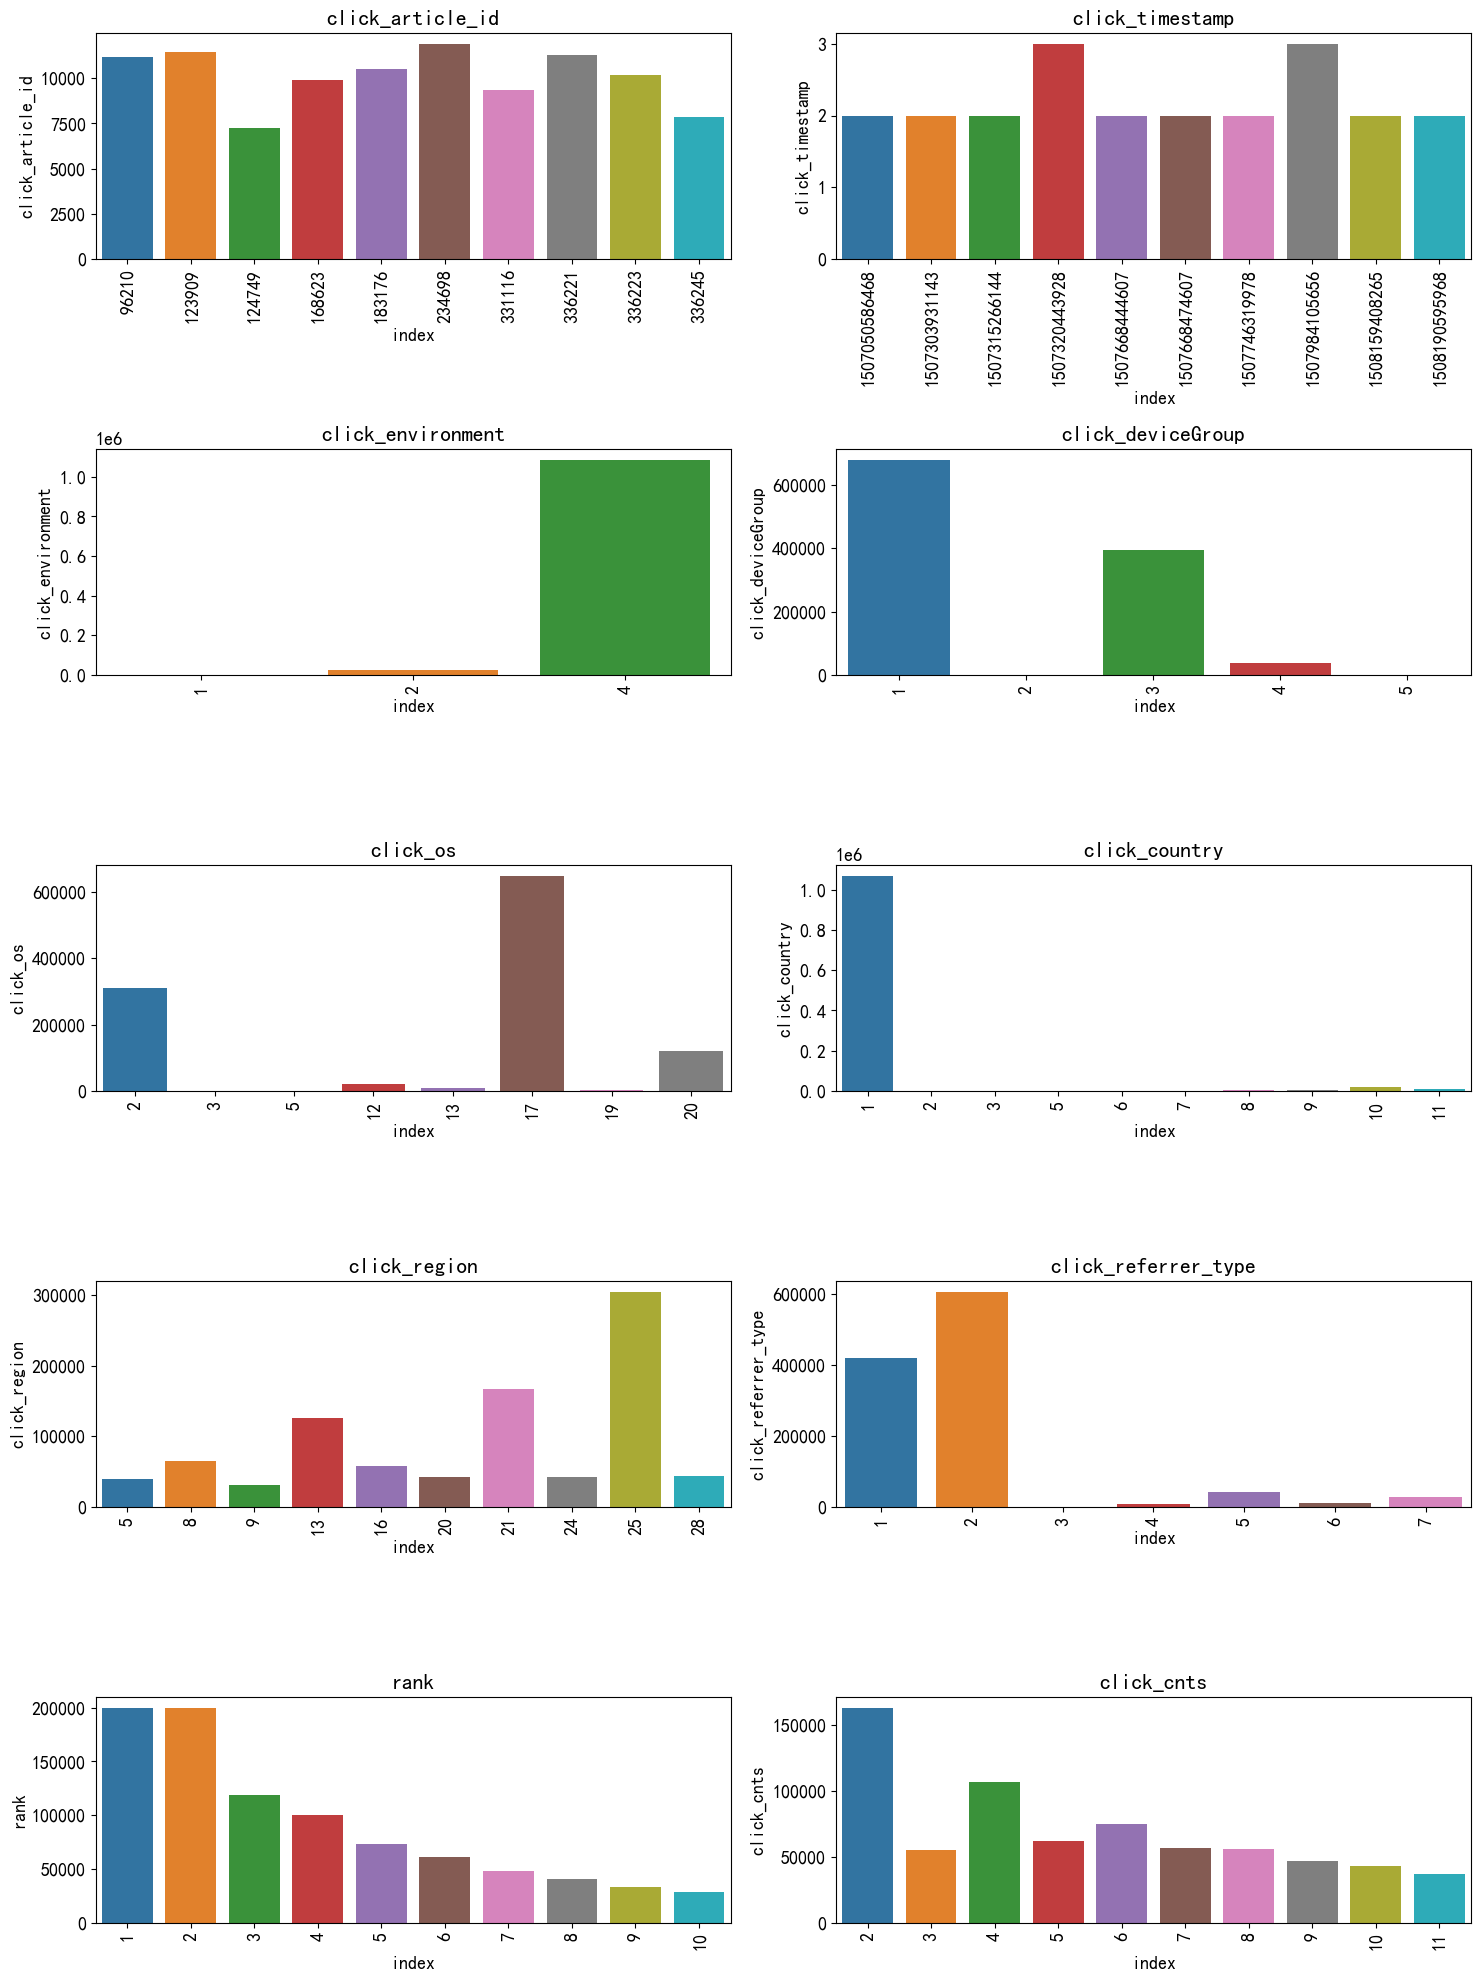

In [12]:
plt.figure()  # 创建一个新的图形窗口

plt.figure(figsize=(15, 20))  # 设置图形窗口的大小为15x20

i = 1  # 初始化计数器

for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country',
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    # 遍历给定的列名列表

    plot_envs = plt.subplot(5, 2, i)  # 创建子图，将子图放置在5x2的网格中的第i个位置
    i += 1  # 计数器加1

    v = trn_click[col].value_counts().reset_index()[:10]  # 统计给定列的值的计数，并选择前10个值

    fig = sns.barplot(x=v['index'], y=v[col])  # 绘制柱状图，x轴为值，y轴为计数
    for item in fig.get_xticklabels():
        item.set_rotation(90)  # 设置x轴标签的旋转角度为90度，以避免重叠

    plt.title(col)  # 设置子图的标题为列名

plt.tight_layout()  # 自动调整子图的布局，避免重叠
plt.show()  # 显示图形窗口


注：此处click_cnts直方图表示的是每篇文章对应用户的点击次数累计图

也可以以用户角度分析，画出每个用户点击文章次数的直方图

<AxesSubplot: >

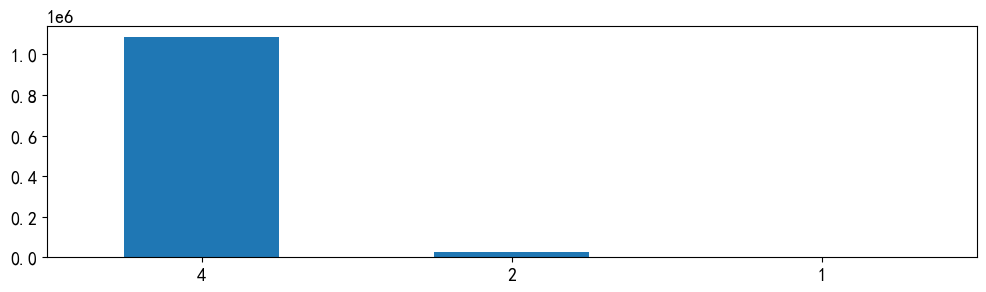

In [13]:
trn_click['click_environment'].value_counts().plot(kind = 'bar',figsize = [12,3],rot = 0)

从点击环境click_environment来看，仅有2102次（占0.19%）点击环境为1；仅有25894次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。

In [14]:
trn_click['click_deviceGroup'].value_counts(normalize = True)

1    0.609539
3    0.355518
4    0.034811
5    0.000127
2    0.000005
Name: click_deviceGroup, dtype: float64

从点击设备组click_deviceGroup来看，设备1占大部分（61%），设备3占36%。

### 测试集用户点击日志

In [15]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [16]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


我们可以看出训练集和测试集的用户是完全不一样的

训练集的用户ID由0 ~ 199999，而测试集A的用户ID由200000 ~ 249999。

因此，也就是我们在训练时，需要把测试集的数据也包括在内，称为全量数据。

!!!!!!!!!!!!!!!后续将对训练集和测试集合并分析!!!!!!!!!!!

In [17]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()

50000

In [18]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

### 新闻文章信息数据表

In [19]:
#新闻文章数据集浏览
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


<AxesSubplot: >

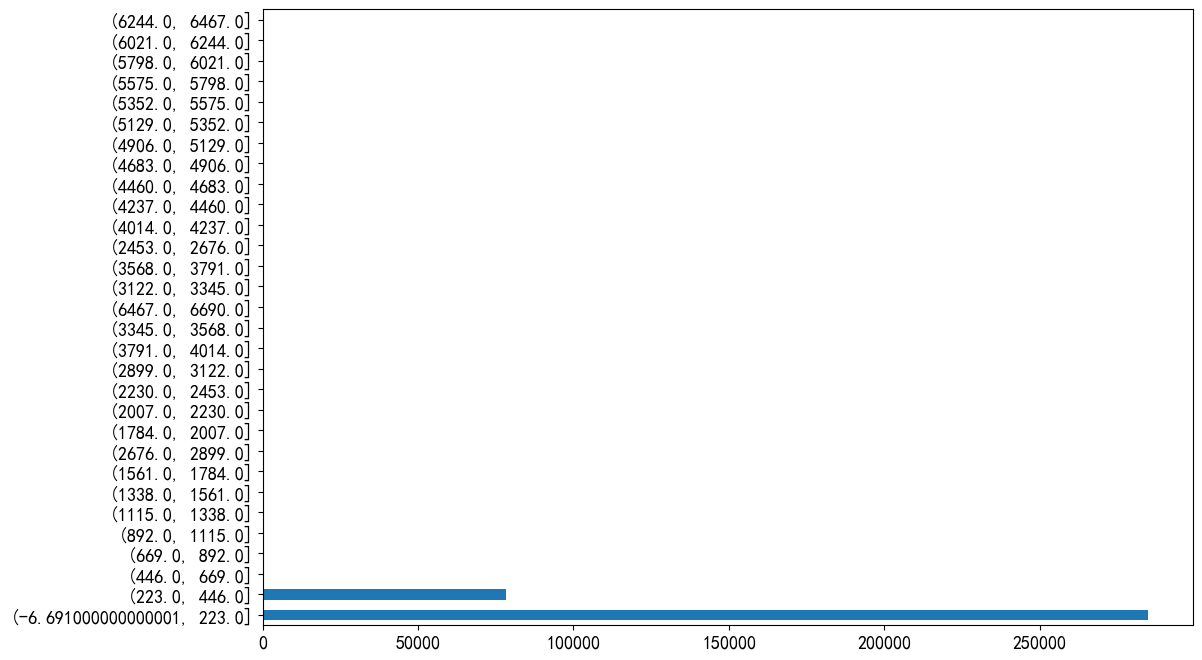

In [20]:
item_df['words_count'].value_counts(bins = 30).plot(kind = 'barh',rot = 0, figsize = [12,8])

461


<AxesSubplot: >

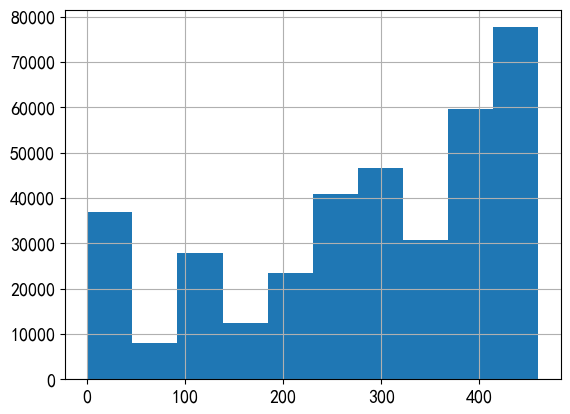

In [21]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

In [22]:
item_df.shape       # 364047篇文章

(364047, 4)

### 新闻文章embedding向量表示

In [23]:
item_emb_df.head()

NameError: name 'item_emb_df' is not defined

In [ ]:
item_emb_df.shape

(364047, 251)

## 数据分析

### 用户重复点击

In [ ]:
#####merge
user_click_merge = trn_click.append(tst_click)

In [ ]:
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [ ]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [ ]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13], dtype=int64)

In [ ]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts()

1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

###### 可以看出：有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章。 这个也可以单独制作成特征

### 用户点击环境变化分析

In [ ]:
def plot_envs(df, cols, r, c):
    """
    绘制多个子图的函数
    :param df: 数据表
    :param cols: 列名列表
    :param r: 子图的行数
    :param c: 子图的列数
    """
    plt.figure()  # 创建一个新的图形窗口
    plt.figure(figsize=(10, 5))  # 设置图形窗口的大小为10x5

    i = 1  # 初始化计数器
    for col in cols:  # 遍历给定的列名列表
        plt.subplot(r, c, i)  # 创建子图，将子图放置在rxc的网格中的第i个位置
        i += 1  # 计数器加1

        v = df[col].value_counts().reset_index()  # 统计给定列的值的计数
        fig = sns.barplot(x=v['index'], y=v[col])  # 绘制柱状图，x轴为值，y轴为计数

        for item in fig.get_xticklabels():
            item.set_rotation(90)  # 设置x轴标签的旋转角度为90度，以避免重叠

        plt.title(col)  # 设置子图的标题为列名

    plt.tight_layout()  # 自动调整子图的布局，避免重叠
    plt.show()  # 显示图形窗口


<Figure size 640x480 with 0 Axes>

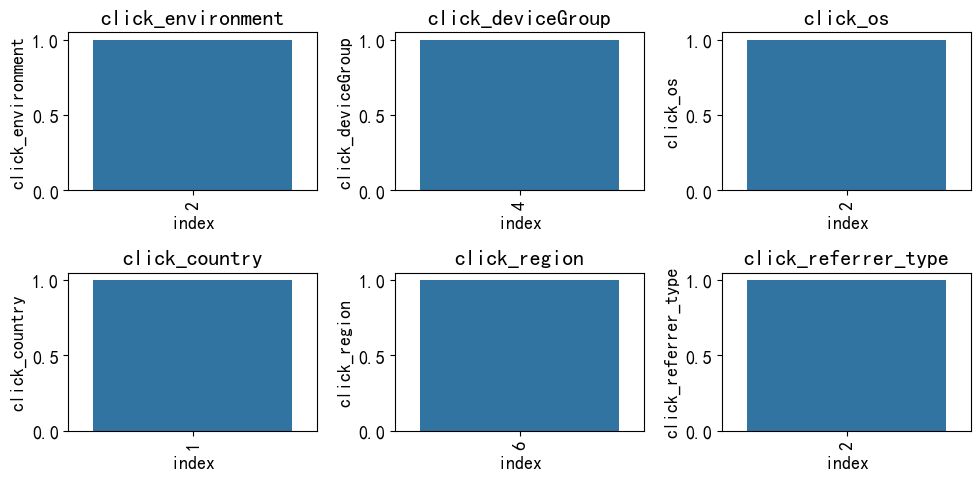

<Figure size 640x480 with 0 Axes>

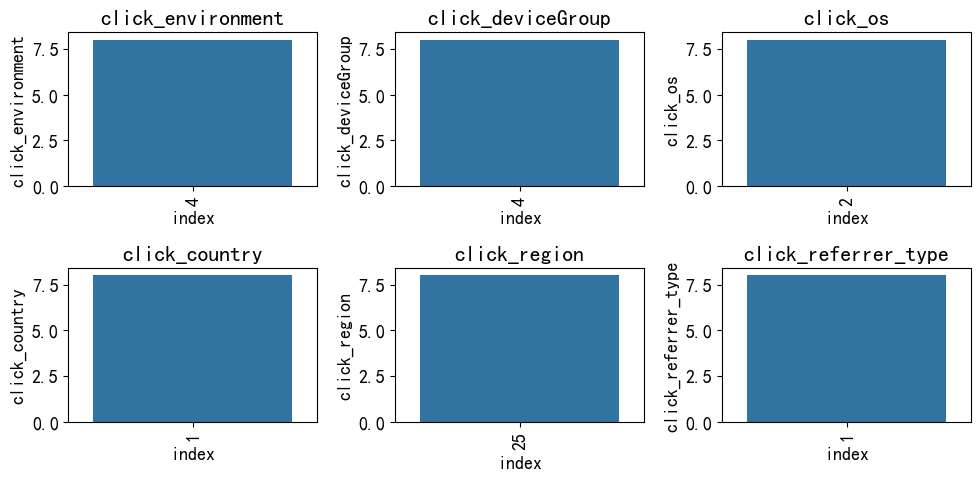

<Figure size 640x480 with 0 Axes>

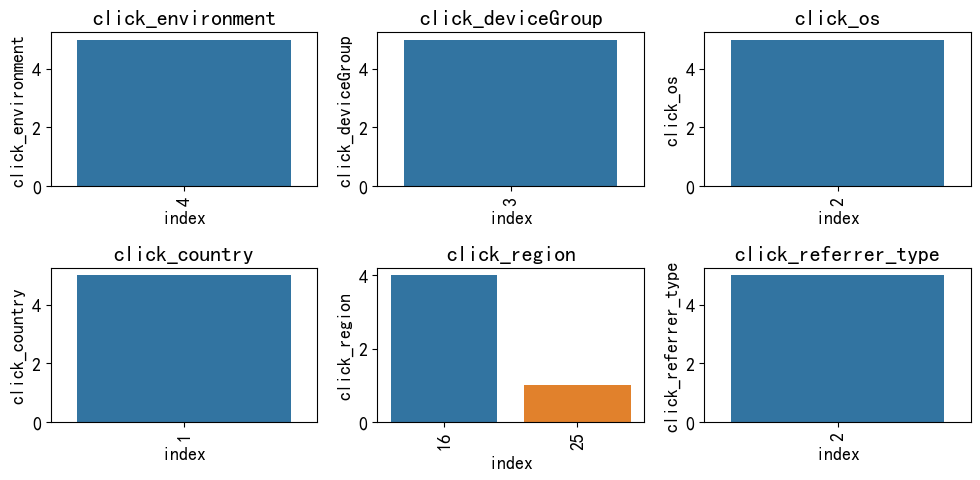

<Figure size 640x480 with 0 Axes>

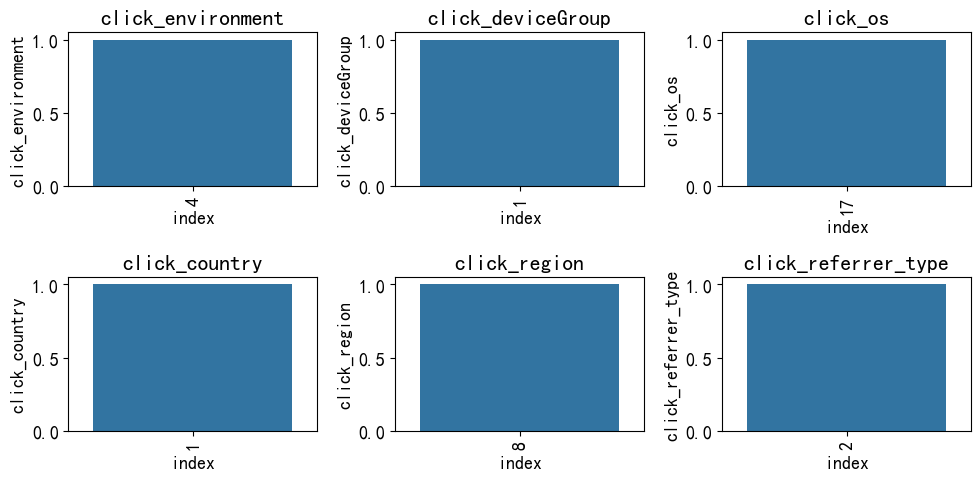

<Figure size 640x480 with 0 Axes>

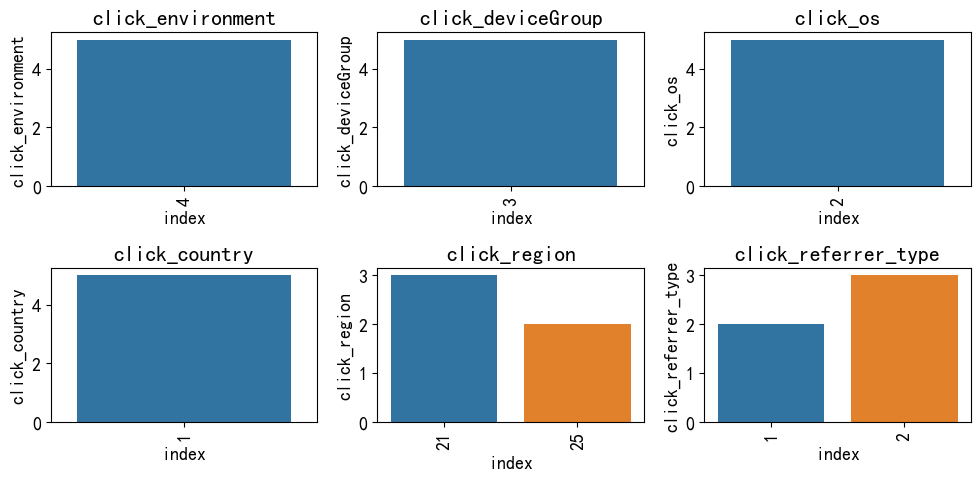

<Figure size 640x480 with 0 Axes>

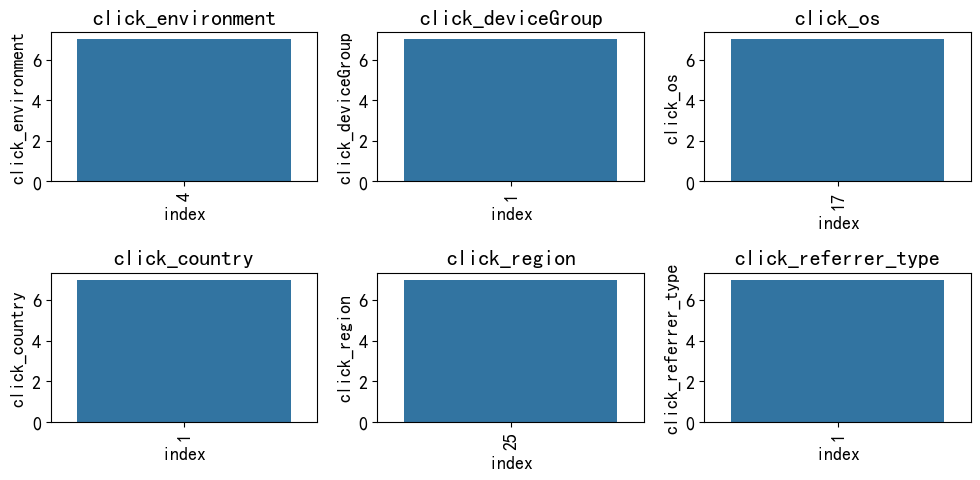

<Figure size 640x480 with 0 Axes>

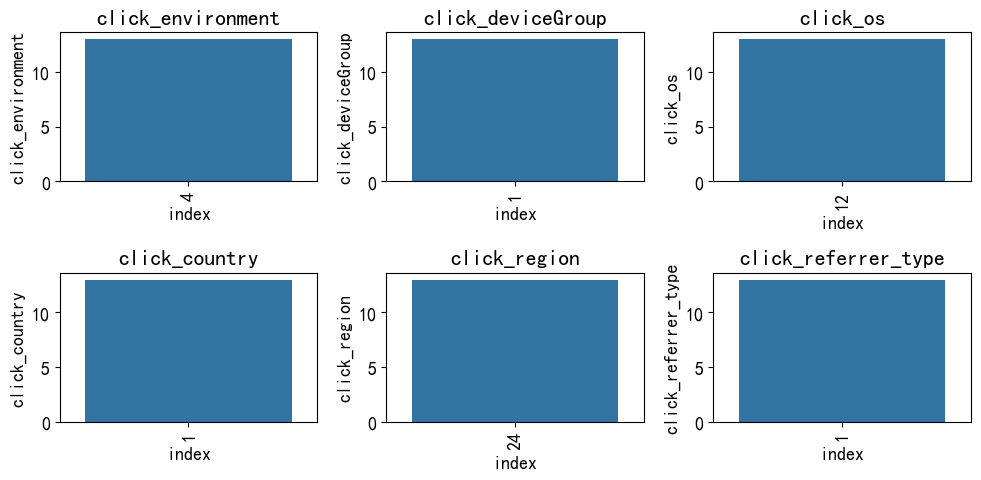

<Figure size 640x480 with 0 Axes>

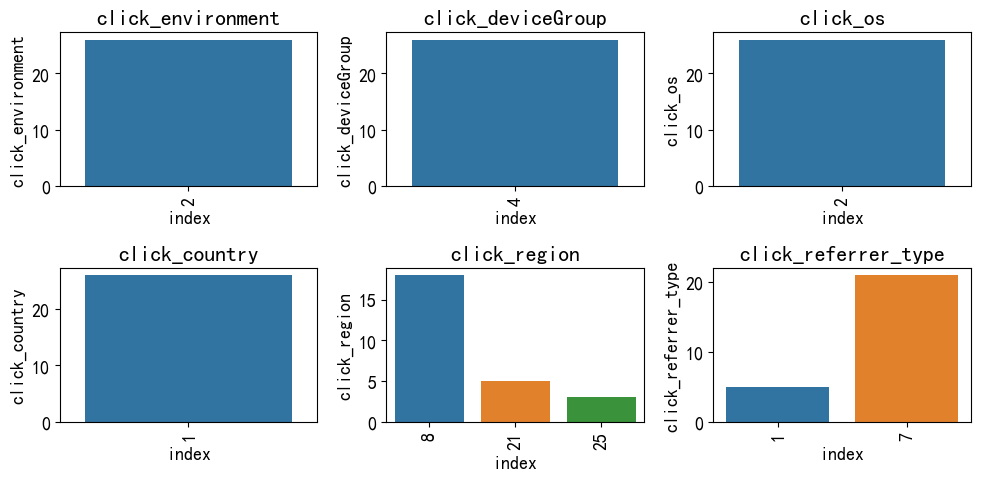

<Figure size 640x480 with 0 Axes>

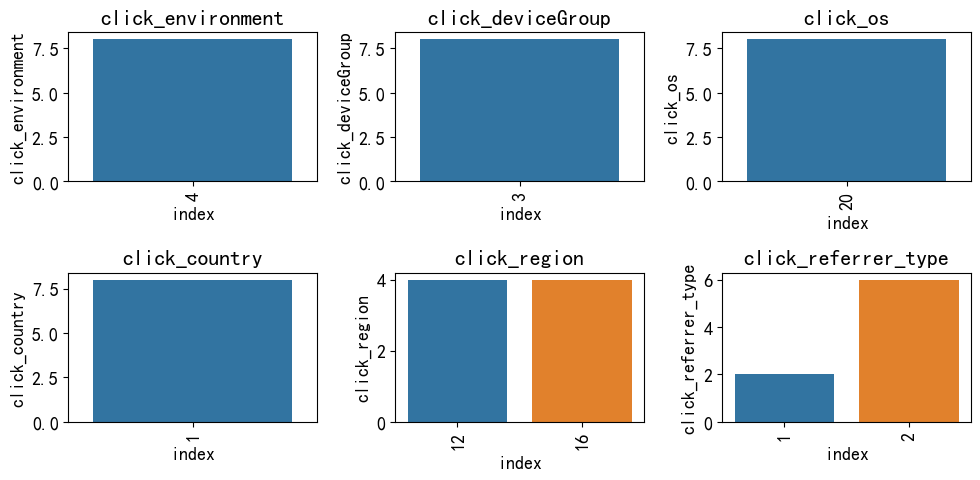

<Figure size 640x480 with 0 Axes>

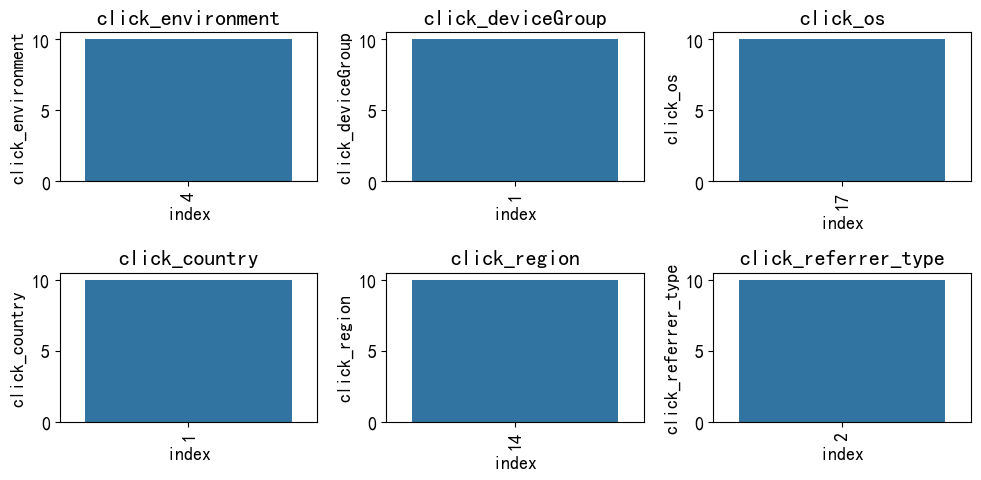

In [ ]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
# 随机采样10个用户
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)

# 从用户点击数据中筛选出采样用户的数据
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]

# 定义要分析的列名列表
cols = ['click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']

# 遍历每个采样用户的数据
for _, user_df in sample_users.groupby('user_id'):
    # 调用plot_envs函数绘制子图
    plot_envs(user_df, cols, 2, 3)


可以看出绝大多数数的用户的点击环境是比较固定的。思路：可以基于这些环境的统计特征来代表该用户本身的属性

### 用户点击新闻数量的分布

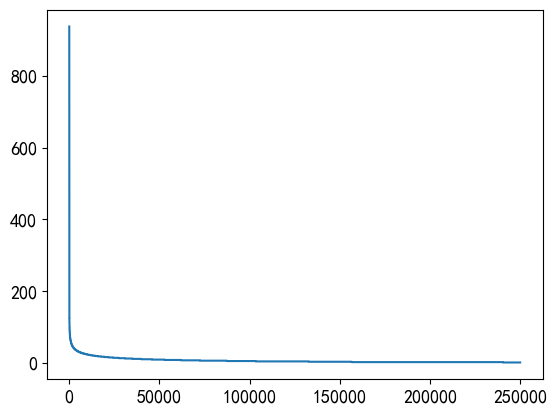

In [ ]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

可以根据用户的点击文章次数看出用户的活跃度

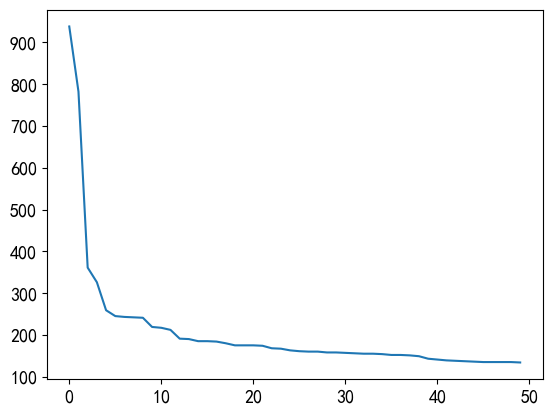

In [ ]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

点击次数排前50的用户的点击次数都在100次以上。思路：我们可以定义点击次数大于等于100次的用户为活跃用户，这是一种简单的处理思路， 判断用户活跃度，更加全面的是再结合上点击时间，后面我们会基于点击次数和点击时间两个方面来判断用户活跃度。

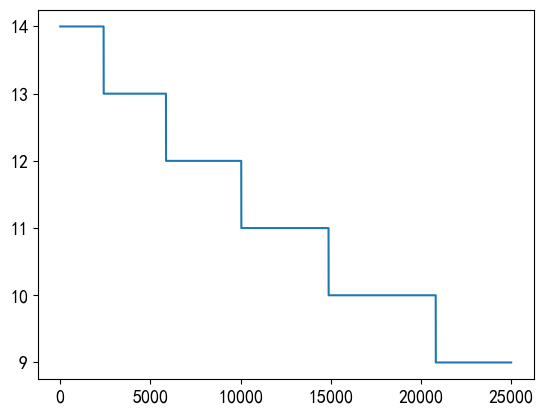

In [ ]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户

### 新闻点击次数分析

In [ ]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)

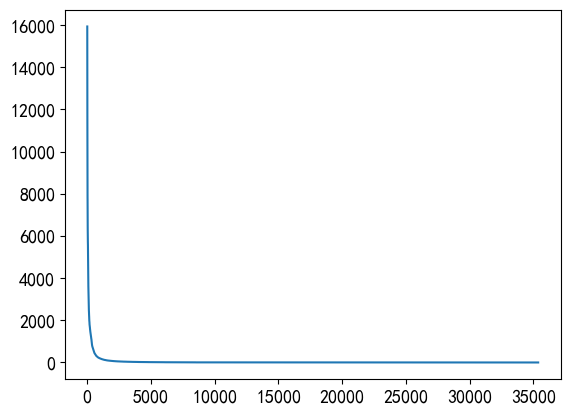

In [ ]:
plt.plot(item_click_count)

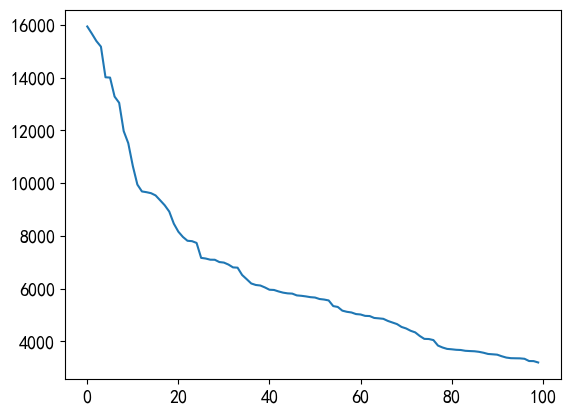

In [ ]:
plt.plot(item_click_count[:100])

可以看出点击次数最多的前100篇新闻，点击次数大于1000次

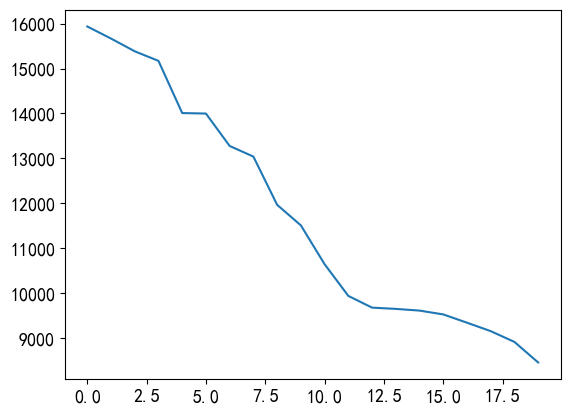

In [ ]:
plt.plot(item_click_count[:20])

点击次数最多的前20篇新闻，点击次数大于2500。思路：可以定义这些新闻为热门新闻， 这个也是简单的处理方式，后面我们也是根据点击次数和时间进行文章热度的一个划分。

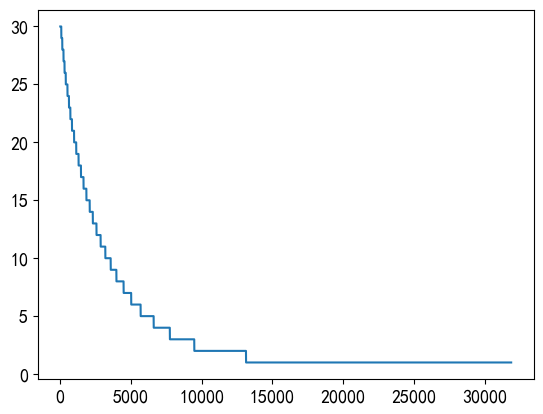

In [ ]:
plt.plot(item_click_count[3500:])

可以发现很多新闻只被点击过一两次。思路：可以定义这些新闻是冷门新闻

### 新闻共现频次：两篇新闻连续出现的次数

In [ ]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


由统计数据可以看出，平均共现次数3.18，最高为2202。

说明用户看的新闻，相关性是比较强的。

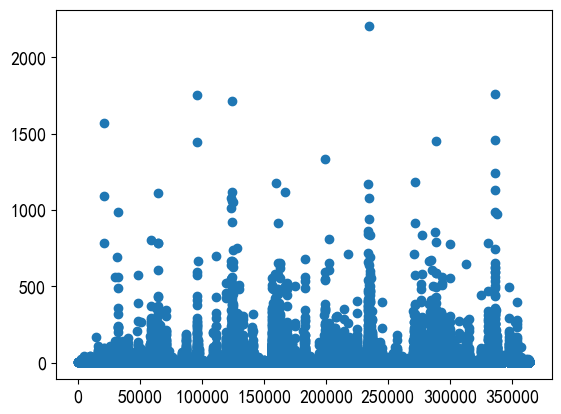

In [ ]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

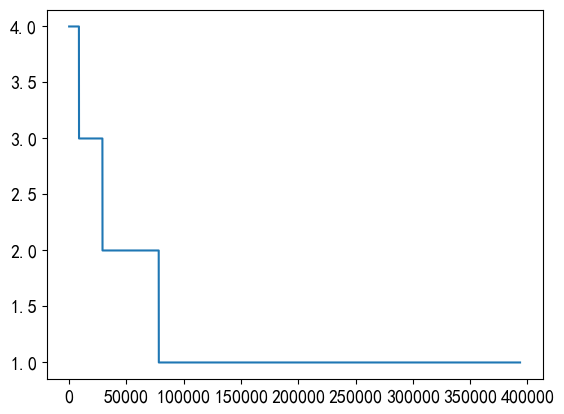

In [ ]:
plt.plot(union_item['count'].values[40000:])

大概有75000个pair至少共现一次

### 新闻文章信息

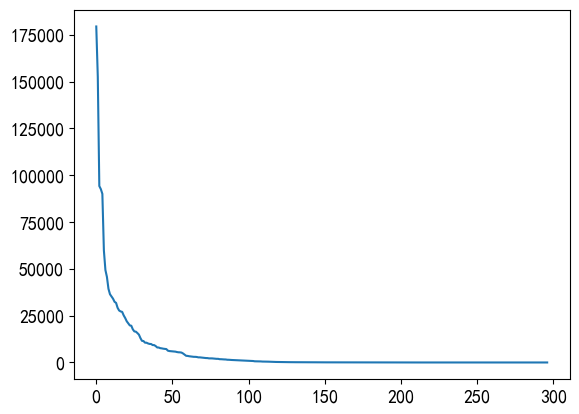

In [ ]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

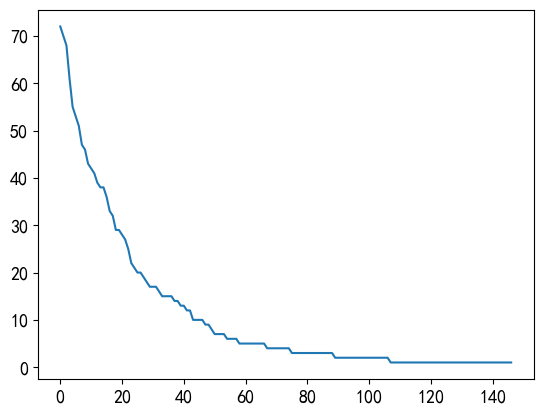

In [ ]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [ ]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

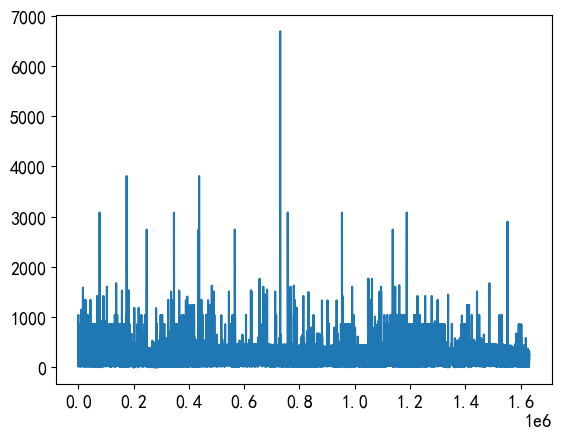

In [ ]:
plt.plot(user_click_merge['words_count'].values)

### 用户点击的新闻类型的偏好

此特征可以用于度量用户的兴趣是否广泛。

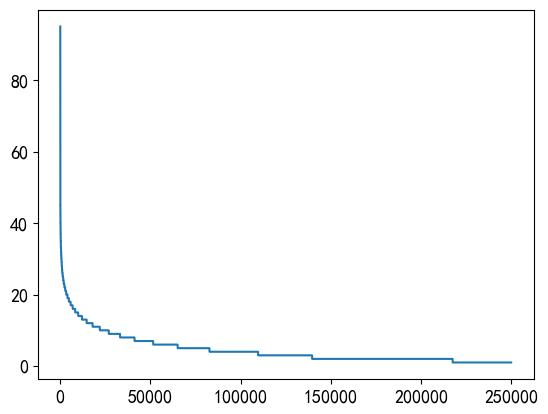

In [ ]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

从上图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在20个新闻类型以下。

In [ ]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


### 用户查看文章的长度的分布

通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

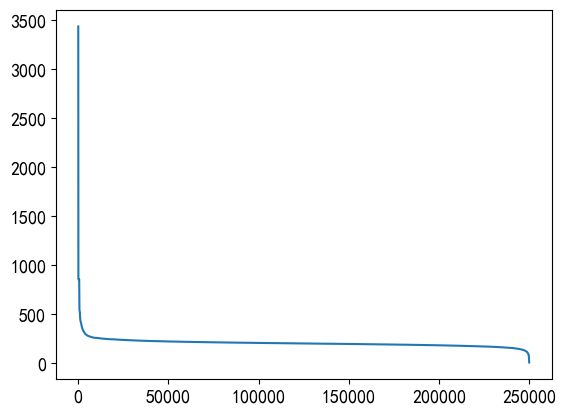

In [ ]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。

大多数人偏好于阅读字数在200-400字之间的新闻。

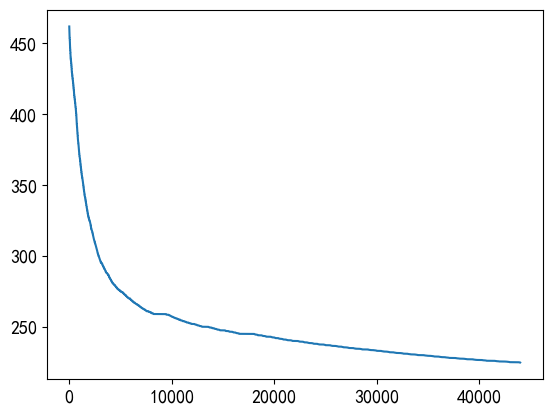

In [ ]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

可以发现大多数人都是看250字以下的文章

In [ ]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


## 用户点击新闻的时间分析

In [ ]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

In [ ]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [ ]:
import pandas as pd

def mean_diff_time_func(df, col):
    df = pd.DataFrame(df[col])  # Pass the list of columns as it is
    df['time_shift1'] = df[col].shift(1).fillna(0)
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    return df['diff_time'].mean()

# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id').apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))


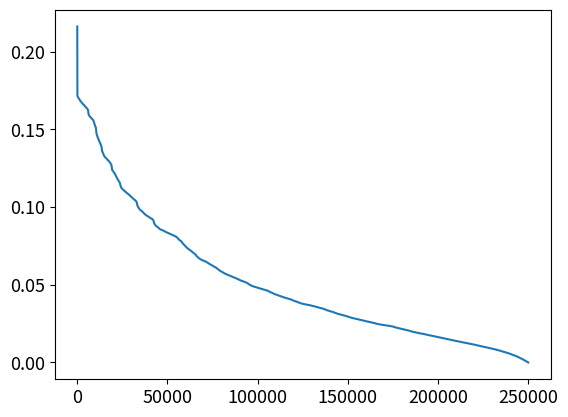

In [ ]:
plt.plot(sorted(mean_diff_click_time.values, reverse=True))

从上图可以发现不同用户点击文章的时间差是有差异的

In [ ]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))

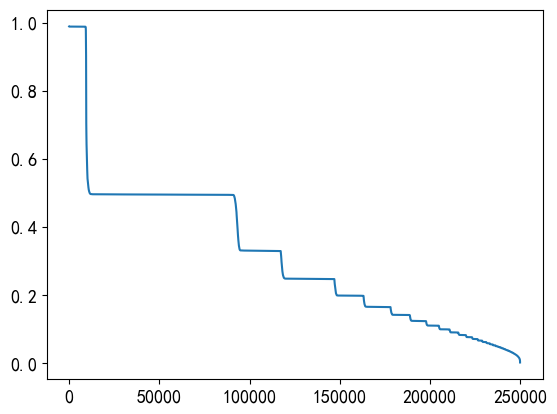

In [ ]:
plt.plot(sorted(mean_diff_created_time.values, reverse=True))

从图中可以发现用户先后点击文章，文章的创建时间也是有差异的

In [ ]:
# 安装gensim
!pip install gensim

In [ ]:
from gensim.models import Word2Vec
import logging, pickle

# Note that the model is trained only once
def train_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # Only string values can be used for training
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # Convert to sentences
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # Set up logging for progress visibility
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # Training the Word2Vec model
    w2v = Word2Vec(sentences=docs, vector_size=16, sg=1, window=5, seed=2020, workers=24, min_count=1)

    # Saving the word embeddings as a dictionary
    item_w2v_emb_dict = {k: w2v.wv[k] for k in w2v.wv.index_to_key}

    return item_w2v_emb_dict


In [ ]:
item_w2v_emb_dict = train_item_word2vec(user_click_merge)

2024-03-31 16:23:21,144:INFO:collecting all words and their counts
2024-03-31 16:23:21,144:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-31 16:23:21,152:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2024-03-31 16:23:21,161:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2024-03-31 16:23:21,170:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2024-03-31 16:23:21,182:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2024-03-31 16:23:21,193:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2024-03-31 16:23:21,207:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2024-03-31 16:23:21,220:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2024-03-31 16:23:21,235:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

In [ ]:
# 随机选择5个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
19379,242192,160974,0.001559,4,1,17,1,9,2,29,29,281,0.989092,259
19380,242192,16129,0.001806,4,1,17,1,9,2,28,29,7,0.989184,200
19381,242192,95743,0.001814,4,1,17,1,9,2,27,29,209,0.989158,159
74821,222140,272143,0.006258,4,3,20,1,25,1,2,2,399,0.989235,184
74822,222140,254489,0.006305,4,3,20,1,25,1,1,2,389,0.989168,185


In [ ]:
# 为了防止出现这个错误，这里修改为使用word2vec训练得到的词向量进行可视化
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

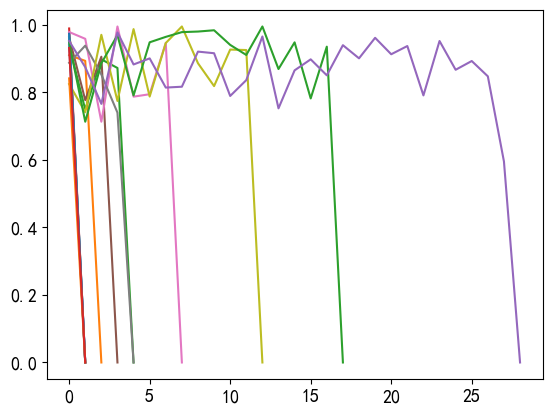

In [ ]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

这里由于对词向量的训练迭代次数不是很多，所以看到的可视化结果不是很准确，可以训练更多次来观察具体的现象。

## 总结
Conclusion from analysis：
1. There are no duplicate user IDs between the training and test sets, meaning the model has not seen the users in the test set before.
2. In the training set, the minimum number of articles clicked by a user is 2, while in the test set, the minimum is 1.
3. Users have clicked on the same article multiple times, but this occurs only in the training set.
4. The click environment of the same user is not unique, statistical features can be used when creating features for this aspect.
5. The number of times a user clicks on articles is highly distinguishable, which can be used to create features measuring user activity.
6. The number of times an article is clicked by users is also highly distinguishable, which can be used to create features measuring article popularity.
7. The news articles viewed by users are quite relevant, so often our judgment of whether a user is interested in an article is largely related to the articles they have clicked on in the past.
8. There is a significant difference in the word count of articles clicked by users, which can reflect user preferences for article length.
9. There is a large difference in the article topics clicked by users, which can reflect user preferences for certain topics.
10. The time difference between article clicks varies among users, which can reflect user preferences for the timeliness of articles.
11. Therefore, based on the above analysis, we can better facilitate our feature engineering and fully mine the hidden information in the data.
